In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [83]:
def plot_boundaries_keras(X_train, y_train, score, probability_func, degree=None, bias=False, h = .02, ax = None, margin=0.5, plot_points=True):
    X = X_train
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    if degree is not None:
        polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree, bias=bias)
        Zaux = probability_func(polynomial_set)
    else:
        Zaux = probability_func(np.c_[xx.ravel(), yy.ravel()])
        # Z = Z_aux[:, 1]
    
    if Zaux.shape[1] == 2:
        Z = Zaux[:, 1]
    else:
        Z = Zaux[:, 0]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    cf = ax.contourf(xx, yy, Z, 50, cmap=cm, alpha=.8, vmin=0.0, vmax=1.0)
    # cf = ax.contourf(xx, yy, Z, 50, cmap=cm, alpha=.8)
    plt.colorbar(cf, ax=ax)
    #plt.colorbar(Z,ax=ax)

    if plot_points:
        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k', s=100)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if score is not None:
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=40, horizontalalignment='right')

In [2]:
def get_spiral_dataset(n = 100, noise=0.05, cicles = 2, seed=42):
    np.random.seed(seed)
    N = n//2
    Noise1 = np.random.normal(0, noise, (N, 2))
    Noise2 = np.random.normal(0, noise, (N, 2))
    r = np.linspace(0.1, 1, N)
    theta = np.linspace(0.1,cicles*2*np.pi, N)
    X1 = np.vstack([r*np.cos(theta), r*np.sin(theta)]).T + Noise1# *r.reshape(-1,1)
    X2 = np.vstack([-r*np.cos(theta), -r*np.sin(theta)]).T + Noise2# *r.reshape(-1,1)
    X = np.vstack([X1, X2]) 
    y = np.array([0]*N + [1]*N)
    return X, y

In [3]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

In [4]:
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [184]:
def get_model(hidden_units=10, input_shape=2, output_size=1, bn=True):
    model_bn = Sequential()
    
    if bn: 
        model_bn.add(Dense(hidden_units,input_dim=input_shape, use_bias=False))
        model_bn.add(BatchNormalization(momentum=0.9))
    else:
        model_bn.add(Dense(hidden_units,input_dim=input_shape))
        
    model_bn.add(Activation('sigmoid'))
    
    if bn:
        model_bn.add(Dense(hidden_units, use_bias=False))
        model_bn.add(BatchNormalization(momentum=0.9))
    else:
        model_bn.add(Dense(hidden_units))
    model_bn.add(Activation('sigmoid'))
    if bn:
        model_bn.add(Dense(hidden_units, use_bias=False))
        model_bn.add(BatchNormalization(momentum=0.9))
    else:
        model_bn.add(Dense(hidden_units))
    model_bn.add(Activation('sigmoid'))
    model_bn.add(Dense(output_size))
    model_bn.add(Activation('sigmoid'))
    return model_bn

In [185]:
model = get_model(bn=False)
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 10)                30        
_________________________________________________________________
activation_171 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_172 (Dense)            (None, 10)                110       
_________________________________________________________________
activation_172 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_173 (Dense)            (None, 10)                110       
_________________________________________________________________
activation_173 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 1)               

In [186]:
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks


In [187]:
model = get_model(bn=True)
model.summary()
selectedOptimizer = optimizers.Adam(lr=0.1)
model.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 10)                20        
_________________________________________________________________
batch_normalization_72 (Batc (None, 10)                40        
_________________________________________________________________
activation_175 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 10)                100       
_________________________________________________________________
batch_normalization_73 (Batc (None, 10)                40        
_________________________________________________________________
activation_176 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 10)              

In [188]:
ropcb = callbacks.ReduceLROnPlateau(verbose=1, patience=50, min_lr=0.0001)
history = model.fit(X, 
          y, batch_size = 256,
          epochs=1000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[ropcb],
         )
print(model.evaluate(X, y))


Epoch 00256: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00653: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00703: ReduceLROnPlateau reducing learning rate to 0.0001.
32/32 [==============================] - 0s 604us/step - loss: 0.1151 - accuracy: 0.9560
[0.11509846150875092, 0.9559999704360962]


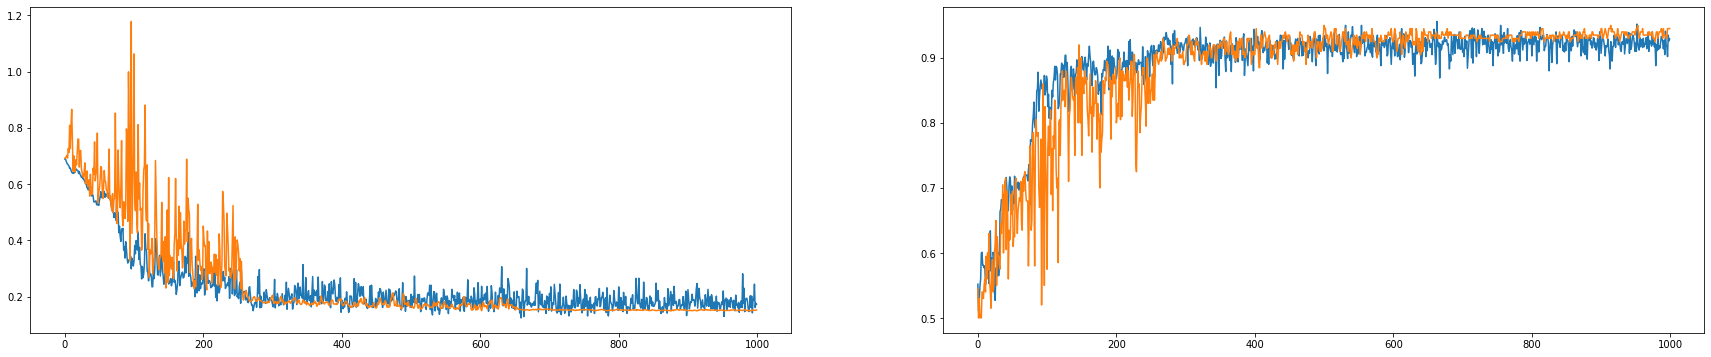

In [189]:
from matplotlib import pyplot as plt
f, axs = plt.subplots(1, 2, figsize=(30, 6))
axs = axs.reshape(-1)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
plt.show()

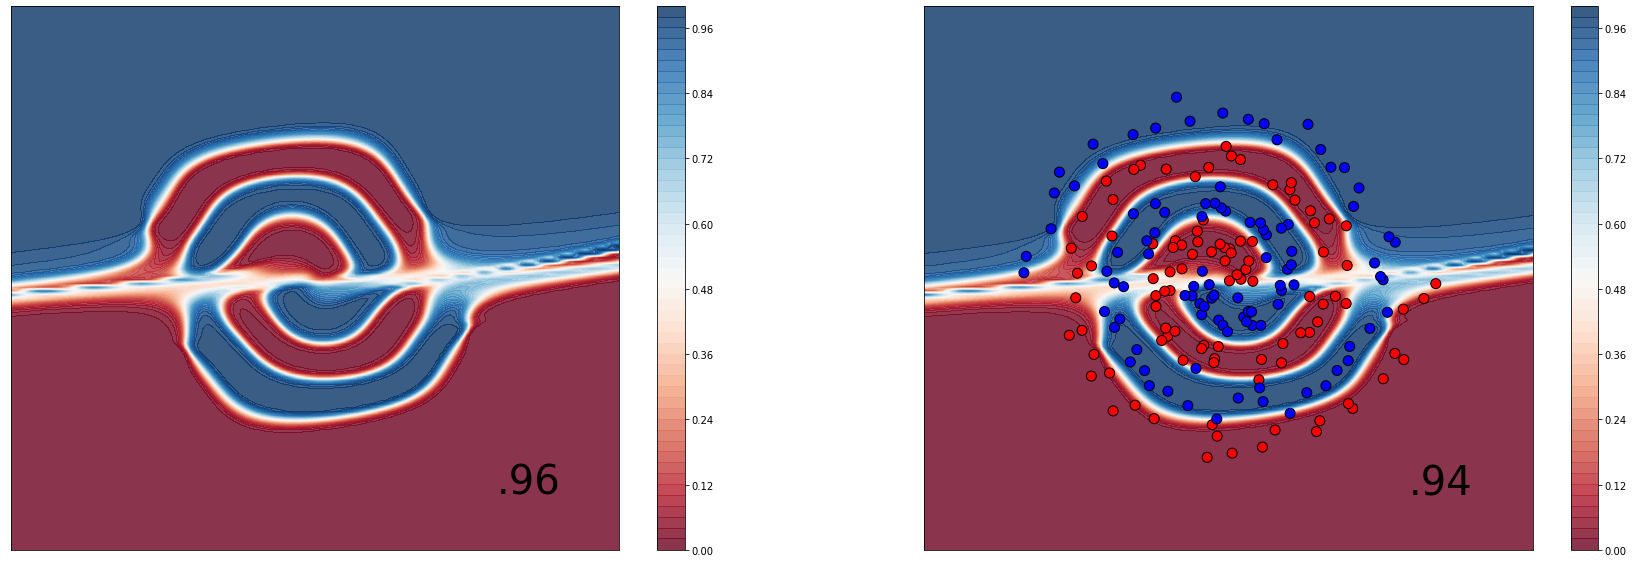

In [190]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
score_nf_train = model.evaluate(X, y, verbose=0)[1]
score_nf_test = model.evaluate(X_test, y_test, verbose=0)[1]
plot_boundaries_keras(X, y, score_nf_train, probability_func=model.predict, ax=ax1, plot_points=False)
plot_boundaries_keras(X_test, y_test, score_nf_test, probability_func=model.predict, ax=ax2)

In [150]:
model_ = get_model(bn=False)
model_.summary()
selectedOptimizer = optimizers.Adam(lr=0.1)
model_.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 10)                30        
_________________________________________________________________
activation_139 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 10)                110       
_________________________________________________________________
activation_140 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 10)                110       
_________________________________________________________________
activation_141 (Activation)  (None, 10)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 1)               

In [151]:
ropcb = callbacks.ReduceLROnPlateau(verbose=1, patience=200, min_lr=0.0001)
history_ = model_.fit(X, 
          y, batch_size = 128,
          epochs=1000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[ropcb],
         )
print(model_.evaluate(X, y))


Epoch 00604: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00804: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
32/32 [==============================] - 0s 624us/step - loss: 0.0383 - accuracy: 0.9840
[0.038298990577459335, 0.984000027179718]


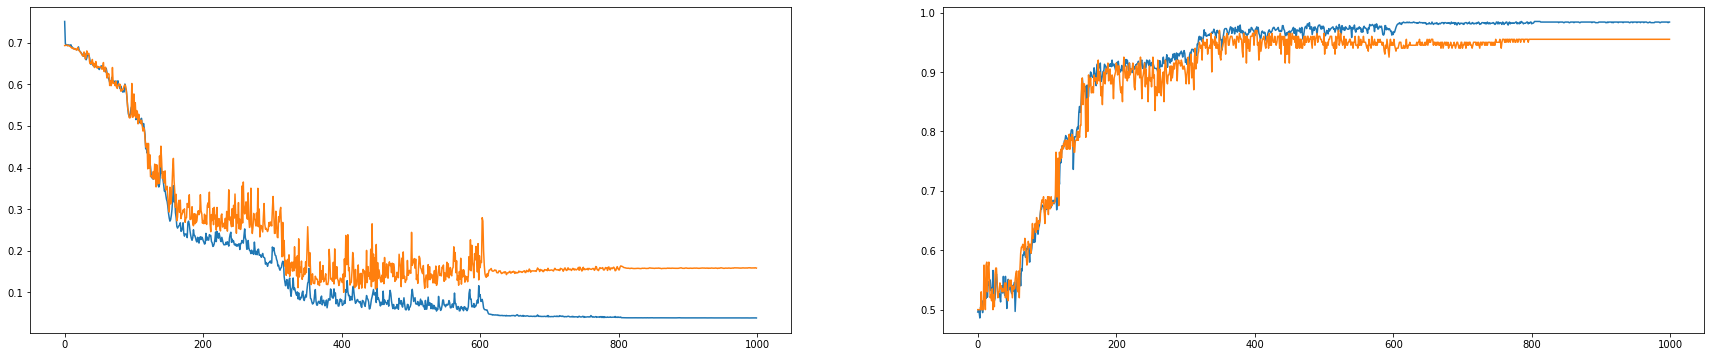

In [152]:
from matplotlib import pyplot as plt
f, axs = plt.subplots(1, 2, figsize=(30, 6))
axs = axs.reshape(-1)
axs[0].plot(history_.history['loss'])
axs[0].plot(history_.history['val_loss'])
axs[1].plot(history_.history['accuracy'])
axs[1].plot(history_.history['val_accuracy'])
plt.show()

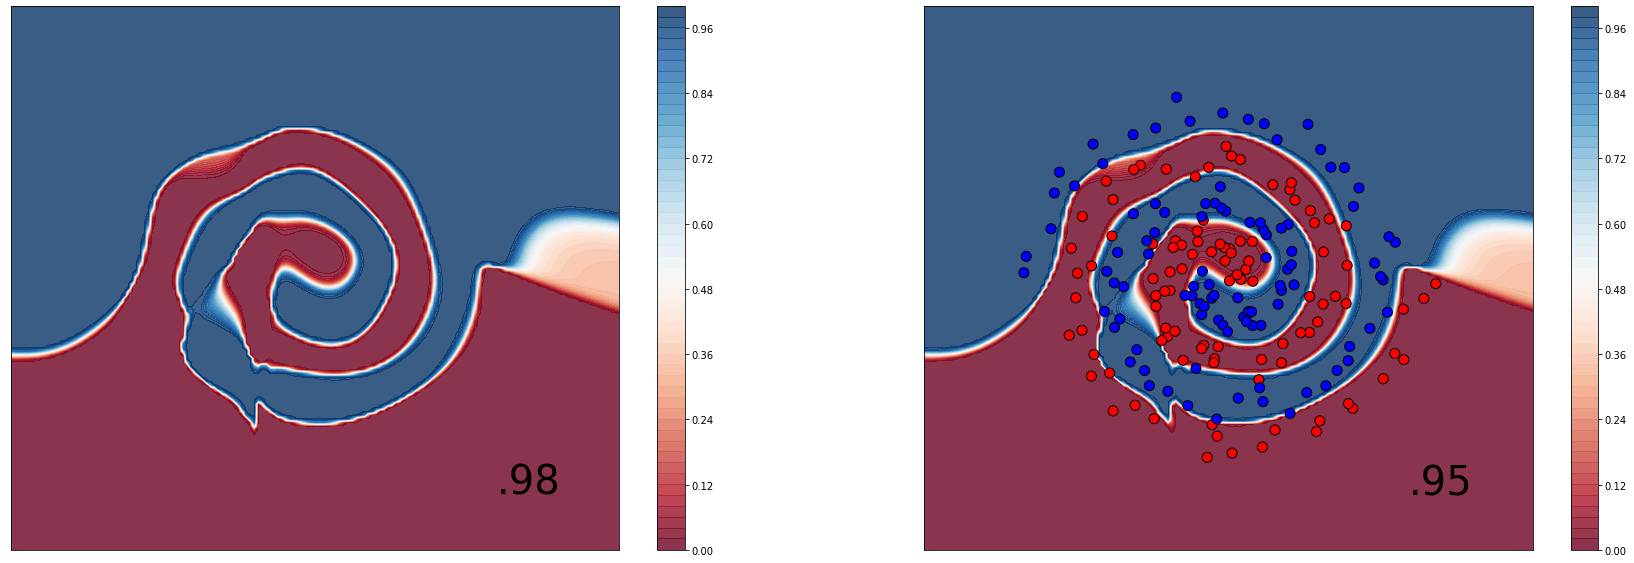

In [153]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
score_nf_train = model_.evaluate(X, y, verbose=0)[1]
score_nf_test = model_.evaluate(X_test, y_test, verbose=0)[1]
plot_boundaries_keras(X, y, score_nf_train, probability_func=model_.predict, ax=ax1, plot_points=False)
plot_boundaries_keras(X_test, y_test, score_nf_test, probability_func=model_.predict, ax=ax2)